# Assignment1 - Text Sentiment Analysis

## Initial Set-up
### Install Relevant Libraries

In [1]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install autocorrect

In [2]:
import time
start_time = time.time()

### Import Relevant Python Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re
import html

sns.set_style('whitegrid')

# The following line is needed to show plots inline in notebooks
%matplotlib inline 

## Import data

The pd.read_csv function was used in order to import both the generic tweets and the US airline tweets into pandas dataframes. Although the txt file is not a .csv file, this function can be used. An advantage is that it is much quicker to use this function than to read in line by line, and the delimiter does not need to be known. 

In [4]:
#import the generic tweet data
genericDF = pd.read_csv('generic_tweets.txt', index_col=False)

#import the tweet data - put in NaN for tweets with no negative_reason
AirlineDF = pd.read_csv('US_airline_tweets.csv', index_col=False, na_values = " ")

The head function is then used in order to verify the data was imported and formatted correctly. 

In [5]:
genericDF.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
AirlineDF.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


# Data Cleaning

In [7]:
from string import printable
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.metrics import edit_distance
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# remove unimportant columns
genericDF.drop(['id','date','query','user'],axis=1,inplace=True)
AirlineDF.drop(['id','user','retweet_count'], axis=1, inplace=True)

# Create a new  column to store the original messy data in lowercase
AirlineDF['messydata'] = AirlineDF['text'].str.lower()
genericDF['messydata'] = genericDF['text'].str.lower()

### Text Cleaning Function
In the below function called TextCleaner, I decided to parse the dataframe using the str.replace() function. I found this method to be simpler, and much faster than using regex functions and looping through the data line by line.
Additionally, I created a function to perform these tasks, rather than type out the cleaning method for each dataframe, because the data cleaning is identical for the generic tweets and the airline tweets.

In [9]:
def TextCleaner(data, colname='text'):
    
    """This function takes the messy data and column name, where the default is 'text', as the input and cleans the data 
    by removing all html tags and attributes, replacing html character codes with an ASCII equivalent, removing all URL's, 
    and putting the text in lowercase """
    
    # Remove unprintable characters
    data[colname] = data[colname].apply(lambda y: ''.join(filter(lambda x: x in printable, y)))
    
    # Remove all html tags and attributes
    data[colname] = data[colname].str.replace('<[^<]+?>', '')
    
    # Replace all html character codes with an ASCII equivalent
    data[colname] = data[colname].apply(lambda x: html.unescape(x))
    
    # Remove URLs by removing anything that starts with http
    data[colname] = data[colname].str.replace(r"http\S+", "")
    
    # Remove hashtags symbol - we still want the hashtag because it might give more insight into the sentiment of the tweet
    data[colname] = data[colname].str.replace(r'#', '')
    
    # Remove twitter handles
    data[colname] = data[colname].str.replace(r'(?:@[\w_]+)', '')
    
    # Remove emojis
    data[colname] = data[colname].str.replace(r"""
            (?:
            [:=;] # Eyes
            [oO\-]? # Nose (optional)
            [D\)\]\(\]/\\OpP] # Mouth
            )""", '')
    
    # Put all characters in lowercase
    data[colname] = data[colname].str.lower()
    
    return data

In [10]:
TextCleaner(AirlineDF)

,sentiment,negative_reason,text,messydata
0,positive,NaN,plus you've added commercials to the experien...,@virginamerica plus you've added commercials t...
1,negative,Bad Flight,"it's really aggressive to blast obnoxious ""en...",@virginamerica it's really aggressive to blast...
2,negative,Can't Tell,and it's a really big bad thing about it,@virginamerica and it's a really big bad thing...
3,negative,Can't Tell,seriously would pay $30 a flight for seats th...,@virginamerica seriously would pay $30 a fligh...
4,positive,NaN,"yes, nearly every time i fly vx this ear worm...","@virginamerica yes, nearly every time i fly vx..."
5,positive,NaN,"well, i didn'tbut now i do! :-d","@virginamerica well, i didn'tâ€¦but now i do! :-d"
6,positive,NaN,"it was amazing, and arrived an hour early. yo...","@virginamerica it was amazing, and arrived an ..."
7,positive,NaN,i <3 pretty graphics. so much better than min...,@virginamerica i &lt;3 pretty graphics. so muc...
8,positive,NaN,this is such a great deal! already thinking a...,@virginamerica this is such a great deal! alre...
9,positive,NaN,i'm flying your fabulous seductive skies aga...,@virginamerica @virginmedia i'm flying your #f...


In [11]:
TextCleaner(genericDF)

,class,text,messydata
0,0,"- awww, that's a bummer. you shoulda got da...","@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,is upset that he can't update his facebook by ...,is upset that he can't update his facebook by ...
2,0,i dived many times for the ball. managed to s...,@kenichan i dived many times for the ball. man...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am...","@nationwideclass no, it's not behaving at all...."
5,0,not the whole crew,@kwesidei not the whole crew
6,0,need a hug,need a hug
7,0,"hey long time no see! yes.. rains a bit ,onl...",@loltrish hey long time no see! yes.. rains a...
8,0,nope they didn't have it,@tatiana_k nope they didn't have it
9,0,que me muera ?,@twittera que me muera ?


## Remove Stop Words

In [12]:
# Create a list called stop that holds all the stop words from the stop_words.txt file 
stop = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def RemoveStopWords(text):
    '''This is a function that will remove the stop words from a given text input. In this case, the stop words are 
    from a pre-defined text file called stop_words'''
    
    tokens = [w for w in word_tokenize(text) if w.isalpha()]
    lemmatize = [wordnet_lemmatizer.lemmatize(w) for w in tokens]
    filtered_text = " ".join(t for t in lemmatize if t not in stop)
    return filtered_text

I found that if I needed to use a for loop, it was much faster to loop through by row in the text column, rather than looping through a range of numbers defined by the length of the dataframe.
Below, I am removing all of the stop words, as predefined in the nltk corpus. I found that the stop words in the provided text file was removing words that were key to the tweet. Some tweets ended up being meaningless when those stop words were removed. Additionally, I decided not to stem any words because it created problems later in my analysis when calculating sentiment score from the corpus.txt file. For example the word aggressive has a sentiment score of -2 however with the word stemmer, it is shortened to aggress. The word aggress is not in the corpus.txt file so it would have been ignored.

In [13]:
def filterDF(data, column='text'):
    '''take the dataframe and column you want to filter as the input and output the filtered data into the specified column.
    The default column is set to text.'''
    
    filtered_tweets = []
    
    for row in data[column]:
        filtered_tweets.append(RemoveStopWords(row))
    
    data[column] = pd.DataFrame(filtered_tweets)
    return data

In [14]:
filterDF(genericDF)

,class,text,messydata
0,0,awww bummer shoulda got david carr third day,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,upset ca update facebook texting might cry res...,is upset that he can't update his facebook by ...
2,0,dived many time ball managed save rest go bound,@kenichan i dived many times for the ball. man...
3,0,whole body feel itchy like fire,my whole body feels itchy and like its on fire
4,0,behaving mad ca see,"@nationwideclass no, it's not behaving at all...."
5,0,whole crew,@kwesidei not the whole crew
6,0,need hug,need a hug
7,0,hey long time see rain bit bit lol fine thanks,@loltrish hey long time no see! yes.. rains a...
8,0,nope,@tatiana_k nope they didn't have it
9,0,que muera,@twittera que me muera ?


In [15]:
filterDF(AirlineDF)

,sentiment,negative_reason,text,messydata
0,positive,NaN,plus added commercial experience tacky,@virginamerica plus you've added commercials t...
1,negative,Bad Flight,really aggressive blast obnoxious entertainmen...,@virginamerica it's really aggressive to blast...
2,negative,Can't Tell,really big bad thing,@virginamerica and it's a really big bad thing...
3,negative,Can't Tell,seriously would pay flight seat playing really...,@virginamerica seriously would pay $30 a fligh...
4,positive,NaN,yes nearly every time fly vx ear worm wont go ...,"@virginamerica yes, nearly every time i fly vx..."
5,positive,NaN,well,"@virginamerica well, i didn'tâ€¦but now i do! :-d"
6,positive,NaN,wa amazing arrived hour early good,"@virginamerica it was amazing, and arrived an ..."
7,positive,NaN,pretty graphic much better minimal iconography,@virginamerica i &lt;3 pretty graphics. so muc...
8,positive,NaN,great deal already thinking trip even gone tri...,@virginamerica this is such a great deal! alre...
9,positive,NaN,flying fabulous seductive sky u take stress aw...,@virginamerica @virginmedia i'm flying your #f...


# Exploratory Data Analysis

In [16]:
# print the first and last five rows of the data, as well as the shape and info so we can do some sanity checks
print(genericDF.head())
print(genericDF.tail())
print(genericDF.columns)
print(genericDF.shape)
print(genericDF.info())

   class                                               text  \
0      0       awww bummer shoulda got david carr third day   
1      0  upset ca update facebook texting might cry res...   
2      0    dived many time ball managed save rest go bound   
3      0                    whole body feel itchy like fire   
4      0                                behaving mad ca see   

                                           messydata  
0  @switchfoot http://twitpic.com/2y1zl - awww, t...  
1  is upset that he can't update his facebook by ...  
2  @kenichan i dived many times for the ball. man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  
        class                                               text  \
199995      4           haha remark maternity leave fired little   
199996      4                                                      
199997      4  okie doke time escape north massa back turned ...   
199998      4      

We can see from the info table that there is no missing data. All 3 columns have a complete set of data equal to the number of rows we counted from the size module

In [17]:
# print the first and last five rows of the data, as well as the shape and info so we can do some sanity checks
print(AirlineDF.head())
print(AirlineDF.tail())
print(AirlineDF.columns)
print(AirlineDF.shape)
print(AirlineDF.info())

  sentiment negative_reason  \
0  positive             NaN   
1  negative      Bad Flight   
2  negative      Can't Tell   
3  negative      Can't Tell   
4  positive             NaN   

                                                text  \
0             plus added commercial experience tacky   
1  really aggressive blast obnoxious entertainmen...   
2                               really big bad thing   
3  seriously would pay flight seat playing really...   
4  yes nearly every time fly vx ear worm wont go ...   

                                           messydata  
0  @virginamerica plus you've added commercials t...  
1  @virginamerica it's really aggressive to blast...  
2  @virginamerica and it's a really big bad thing...  
3  @virginamerica seriously would pay $30 a fligh...  
4  @virginamerica yes, nearly every time i fly vx...  
      sentiment         negative_reason  \
11536  negative        Cancelled Flight   
11537  negative             Late Flight   
11538  positive  

We can see all the columns have complete data except for the negative_reason only has 9178 entries. We should count the number of positive vs. negative sentiment tweets to make sure this makes sense and that we aren't actually missing data.

In [18]:
# I want to make sure the number of negative reasons and the number of negative sentiments are equal
print(AirlineDF.sentiment.value_counts())
print(AirlineDF.negative_reason.value_counts(dropna = False))

negative    9178
positive    2363
Name: sentiment, dtype: int64
Customer Service Issue         2910
NaN                            2363
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negative_reason, dtype: int64


We can clearly see the number of negative_reason columns with NaN correspond directly with the number of positive sentiment tweets. This makes sense - positive tweets should not have a negative reason.

### Plot of the number of positive and negative sentiment tweets

Text(0.5, 1.0, 'Plot of number of negative and positive tweets')

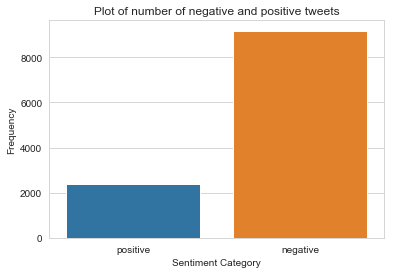

In [19]:
sns.countplot(x='sentiment', data=AirlineDF)
plt.ylabel('Frequency')
plt.xlabel('Sentiment Category')
plt.title('Plot of number of negative and positive tweets')

Clearly, people tend to tweet more about their negative experiences with airlines than positive. Let's now see a breakdown of what the reasons are for the negative tweet generally, and then later on for each airline.

### Plot of the reasons given for the negative sentiment tweets

I want to view a plot of all of the negative reasons that were given on each airline tweet. You can see in the plot below that customer service is generally the biggest issue, however it does not show how the negative reasons are distributed for each airline. In the next section, a function is created to determine each airline so we can view the distribution.

In [20]:
print(AirlineDF.negative_reason.value_counts())

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negative_reason, dtype: int64


Text(0.5, 1.0, 'Plot of negative reasons for each airline')

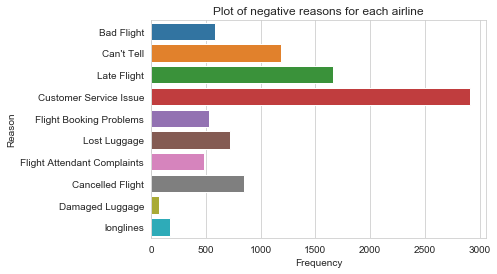

In [21]:
#Plot a histogram of the negative reasons
sns.countplot(y='negative_reason',data=AirlineDF)
plt.title('Plot of negative reasons given')
plt.xlabel('Frequency')
plt.ylabel('Reason')
plt.title('Plot of negative reasons for each airline')

### Length of Tweets

The length of the tweets before and after data cleaning are calculated to view how the tweets change. One of the tweets went from around a length of 140 to 0. The length will be also be used later in analysis as a feature for the logicistic regression algorithm.

In [22]:
# calculate the length of each tweet after data cleaning
AirlineDF['length'] = AirlineDF['text'].apply(len)
genericDF['length'] = genericDF['text'].apply(len)

# calculate the length of each tweet from the generic tweets before data cleaning
clean_length = genericDF['text'].apply(len)
messy_length = genericDF['messydata'].apply(len)

Text(0.5, 1.0, 'Plot of cleaned tweet length vs original tweet length')

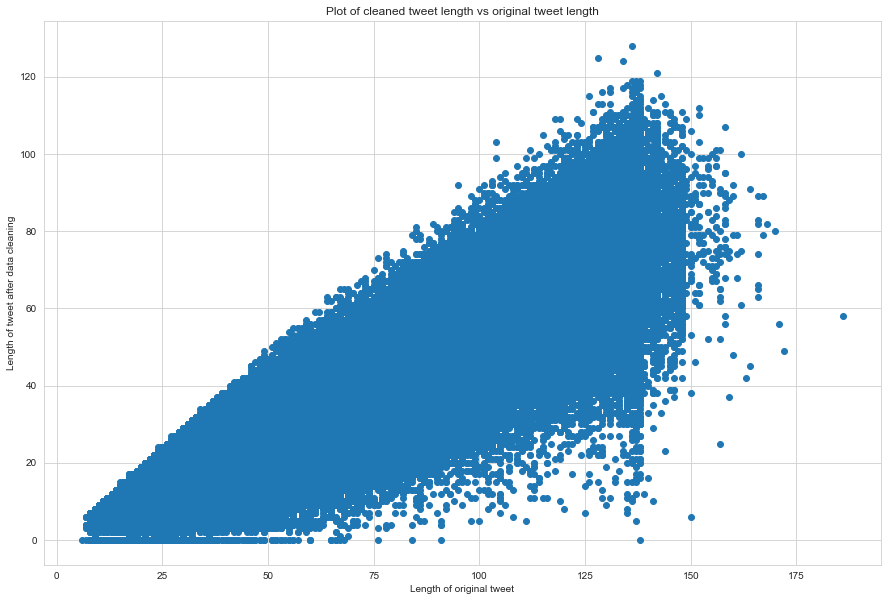

In [23]:
fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)
plt.scatter(messy_length, clean_length)
plt.ylabel('Length of tweet after data cleaning')
plt.xlabel('Length of original tweet')
plt.title('Plot of cleaned tweet length vs original tweet length')

## Determination of Airlines 

In order to determine the airline for each tweet, I defined a function called airline which takes a tweet as its input argument. This function uses if statements and the known twitter handles to check if that airline is mentioned in the tweet. If the airline is mentioned, it is added to a list called Airlines.
To use this method, there are some assumptions that must be made. After taking a look at the data, it is clear that numerous tweets mention several airline twitter handles. One of the limitations of this method is that it cannot detect the context of the mentions within the tweet. Most likely, an additional NLP machine learning method would need to be used to determine which airline the tweet is being directed at. In our case, we are assuming that the first airline that is found is the intended airline. Another limitation is the order in which the if statements are defined. If a tweet mentions both virginamerica and united, it will always find the virginamerica handle first, even if united is mentioned first. This method is not perfect, however for our purposes it still gives us a good idea of the trending issues with each airline we are concerned about. 

In [24]:
def airline(tweet):
    """input a tweet to determine the airline"""
    Airlines = []
    
    if '@virginamerica' in tweet:
        Airlines.append('Virgin')
    if '@united' in tweet:
        Airlines.append('United')
    if '@americanair' in tweet:
        Airlines.append('American')
    if '@usairways' in tweet:
        Airlines.append('USAirways')
    if '@southwestair' in tweet:
        Airlines.append('Southwest')
    if '@jetblue' in tweet:
        Airlines.append('Jet Blue')
    if '@delta' in tweet:
        Airlines.append('Delta')
    if '@spiritairlines' in tweet:
        Airlines.append('Spirit')
      
    return Airlines

Here we define Airline_Group as the list of all airlines in the AirlineDF. This list is created by looping over the "messy data" row by row. I decided to run a for loop on the messy data because I had previously removed all twitter handles in the data cleaning function. 

In [25]:
text = AirlineDF["messydata"]
Airlines_Group = []

for row in text:
    Airlines_Group.append(airline(row))

The list was then converted into a pandas dataframe with the columns: lead_airline, second, third, fourth, fifth. The lead_airline column is what is assumed to be the airline for the tweet. The second, third, fourth, and fifth columns are the other airline handles that were found in the tweet. You can see from the head() function that several tweets only have one airline mentioned. This is why it is safe to assume that the first airline mentioned is the intended airline that the tweet was directed at. 

In [26]:
Airlines_GroupDF = pd.DataFrame(Airlines_Group, columns=['lead_airline', 'second', 'third', 'fourth', 'fifth'])

# Add a new airline column that takes the first airline from the dataframe
AirlineDF['airline'] = Airlines_GroupDF['lead_airline']
print(Airlines_GroupDF.head(20))
print('\n')
print(AirlineDF.airline.value_counts())

   lead_airline second third fourth fifth
0        Virgin   None  None   None  None
1        Virgin   None  None   None  None
2        Virgin   None  None   None  None
3        Virgin   None  None   None  None
4        Virgin   None  None   None  None
5        Virgin   None  None   None  None
6        Virgin   None  None   None  None
7        Virgin   None  None   None  None
8        Virgin   None  None   None  None
9        Virgin   None  None   None  None
10       Virgin   None  None   None  None
11       Virgin   None  None   None  None
12       Virgin   None  None   None  None
13       Virgin   None  None   None  None
14       Virgin   None  None   None  None
15       Virgin   None  None   None  None
16       Virgin   None  None   None  None
17       Virgin   None  None   None  None
18       Virgin   None  None   None  None
19       Virgin   None  None   None  None


United       3159
American     2415
USAirways    2404
Southwest    1736
Jet Blue     1482
Virgin        342
Delta   

### Plot of the distribution of negative reasons for each airline

Text(0.5, 1.0, 'Plot of the distribution of negative reasons for each airline')

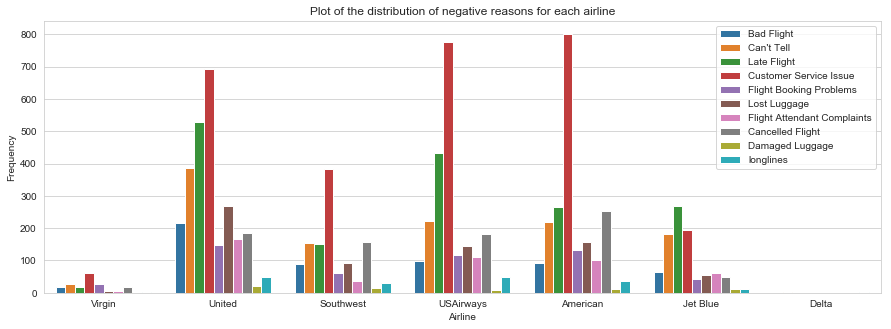

In [27]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(1,1,1)
sns.countplot(x ='airline' , hue='negative_reason', data=AirlineDF)

# put legend in the upper right hand corner of the plot
plt.legend(loc=1)
plt.ylabel('Frequency')
plt.xlabel('Airline')
plt.title('Plot of the distribution of negative reasons for each airline')

From the chart pictured above, you can see that for most airlines, the biggest issue is Customer Service. However, for JetBlue their biggest issue is late flights. We can also see that damaged luggage is not a very big issue for any of the airlines. The next step would be for the airlines to look at the tweets that are categorized as a customer service issue. The analyst could then look at the main topics of these tweets to see what exactly can be improved in their customer service.

Since Delta airlines only has 2 tweets, I decided to create a separate plot to view the negative reasons. Delta only had 1 Long lines and 1 can't tell. 

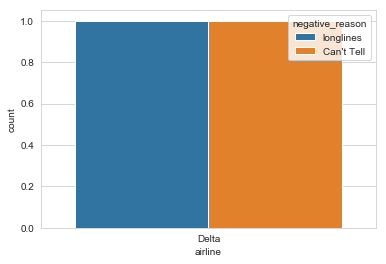

In [28]:
sns.countplot(x = 'airline', hue = 'negative_reason', data=AirlineDF[AirlineDF['airline'] == 'Delta'])

In [29]:
AirlineDF[AirlineDF['airline'] == 'Delta'].head()

,sentiment,negative_reason,text,messydata,length,airline
9368,negative,longlines,minute waiting silver elite line someone pick ...,@deltaassist now at 57 minutes waiting on silv...,50,Delta
9369,negative,Can't Tell,say character plus follow,@deltaassist what i have to say is more than 1...,25,Delta


# Model Preparation

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from scipy.sparse import coo_matrix, hstack

### Calculating sentiment scores

In order to train the data, I decided to calculate a sentiment score for each tweet. Using the corpus.txt file that was given..........

In [31]:
nopunctokenizer = RegexpTokenizer('\w+')
values = pd.read_csv('corpus.txt', sep = '\t', header=None, names=['word', 'score'])

def SentimentScore(tweet):
    '''this is a simple function that takes a tokenized tweet as input and returns a sentiment score based on values 
    in the corpus.txt file given'''
    
    score = 0
    for word in tweet:
        for index, term in enumerate(values['word']):
            if term == word:
                score += values['score'].iloc[index]
    return score

In [32]:
def getsentimentDF(data, column='text'):
    '''implement the SentimentScore function and loop through the dataframe to calculate the sentiment score for each
    tweet into a dataframe. Add this dataframe as a new column called SentimentScore'''
    
    score = []
    
    for tweet in data[column]:
        sentence = nopunctokenizer.tokenize(tweet)
        if len(sentence) > 0:
            #score.append(SentimentScore(sentence)/len(sentence))
            score.append(SentimentScore(sentence))
        else:
            score.append(0)
    
    scoreDF = pd.DataFrame(score, columns = ['SentimentScore'])
    data['SentimentScore'] = scoreDF
    
    return data

In [33]:
getsentimentDF(genericDF)

,class,text,messydata,length,SentimentScore
0,0,awww bummer shoulda got david carr third day,"@switchfoot http://twitpic.com/2y1zl - awww, t...",44,-2
1,0,upset ca update facebook texting might cry res...,is upset that he can't update his facebook by ...,72,-5
2,0,dived many time ball managed save rest go bound,@kenichan i dived many times for the ball. man...,47,2
3,0,whole body feel itchy like fire,my whole body feels itchy and like its on fire,31,-2
4,0,behaving mad ca see,"@nationwideclass no, it's not behaving at all....",19,-3
5,0,whole crew,@kwesidei not the whole crew,10,0
6,0,need hug,need a hug,8,2
7,0,hey long time see rain bit bit lol fine thanks,@loltrish hey long time no see! yes.. rains a...,46,7
8,0,nope,@tatiana_k nope they didn't have it,4,0
9,0,que muera,@twittera que me muera ?,9,0


In [34]:
getsentimentDF(AirlineDF) 

,sentiment,negative_reason,text,messydata,length,airline,SentimentScore
0,positive,NaN,plus added commercial experience tacky,@virginamerica plus you've added commercials t...,38,Virgin,0
1,negative,Bad Flight,really aggressive blast obnoxious entertainmen...,@virginamerica it's really aggressive to blast...,74,Virgin,-5
2,negative,Can't Tell,really big bad thing,@virginamerica and it's a really big bad thing...,20,Virgin,-2
3,negative,Can't Tell,seriously would pay flight seat playing really...,@virginamerica seriously would pay $30 a fligh...,66,Virgin,-4
4,positive,NaN,yes nearly every time fly vx ear worm wont go ...,"@virginamerica yes, nearly every time i fly vx...",50,Virgin,1
5,positive,NaN,well,"@virginamerica well, i didn'tâ€¦but now i do! :-d",4,Virgin,0
6,positive,NaN,wa amazing arrived hour early good,"@virginamerica it was amazing, and arrived an ...",34,Virgin,7
7,positive,NaN,pretty graphic much better minimal iconography,@virginamerica i &lt;3 pretty graphics. so muc...,46,Virgin,3
8,positive,NaN,great deal already thinking trip even gone tri...,@virginamerica this is such a great deal! alre...,53,Virgin,3
9,positive,NaN,flying fabulous seductive sky u take stress aw...,@virginamerica @virginmedia i'm flying your #f...,55,Virgin,4


### Bag of Words

In [35]:
def Bag_of_Words(data, column='text', max_f=2000):
    
    """This function creates a bag of words from the text column of the specified data. Thanks to Group 7 for this code"""
    
    #applying the function TfidfVectorizer on the text of all the articles and creating Tf-IDF matrix 
    vectorizer = TfidfVectorizer(token_pattern='[a-zA-Z]+', ngram_range=(1,2), max_df=0.7, max_features = max_f)
    X = vectorizer.fit_transform(data[column])

    Y = pd.DataFrame(X.toarray())
    Y.columns = vectorizer.get_feature_names()
    
    #finding top 7 words in each tweet whose TF-IDF feature is more than the other words in the vocabulary
    arank = Y.apply(np.argsort, axis=1)
    ranked_cols = Y.columns.to_series()[arank.values[:,::-1][:,:7]]
    new_frame = pd.DataFrame(ranked_cols, index=Y.index)
    
    #applying the function CountVectorizer on the text of all the tweets and creating Word-Count matrix 
    U = CountVectorizer(token_pattern='[a-zA-Z]+', ngram_range=(1,2), max_features = max_f)
    P = U.fit_transform(data[column])

    #saving tfidf matrix into a data frame
    tfidf = X.toarray(order=None, out=None)
    tfidf_df = pd.DataFrame(tfidf)
    tfidf_df['SentimentScore'] = data.SentimentScore
    tfidf_df['length'] = data.length
    
    #saving Word-Count matrix into a data frame
    count = P.toarray(order=None, out=None)
    count_df = pd.DataFrame(count)
    count_df['SentimentScore'] = data.SentimentScore
    count_df['length'] = data.length
    
    #create sparse matrix
    tfidf_df_sparse = sparse.csr_matrix(tfidf_df)
    CountWord_df_sparse = sparse.csr_matrix(count_df)
    Features = hstack([tfidf_df_sparse,CountWord_df_sparse])

    Vocabulary = vectorizer.get_feature_names()
    
    return(new_frame, Features, Vocabulary)

In [36]:
important_words, generic_Features, Vocabulary = Bag_of_Words(data=genericDF)

In [37]:
Airline_important_words, Airline_Features, Airline_Vocabulary = Bag_of_Words(data=AirlineDF)

### Splitting generic tweet data into training and testing

In [38]:
y = genericDF['class']
X = generic_Features
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

## Logistic Regression

In [39]:
LR = LogisticRegression(penalty='l1', solver='liblinear')
LR.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
predictions = LR.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("This model got an accuracy of {}% on the testing set".format(round(accuracy*100,2))) 

This model got an accuracy of 76.18% on the testing set


In [41]:
# Create a new column for sentiment class where positive is class 4 and negative is class 0
AirlineDF['class'] = AirlineDF['sentiment'].apply(lambda x: 4 if x == 'positive' else 0)

In [42]:
Airline_Predictions = LR.predict(Airline_Features)

# Create a new column called predicted to visually compare the given class with the predicted value
AirlineDF['predicted'] = pd.DataFrame(Airline_Predictions)
Airline_accuracy = accuracy_score(AirlineDF['class'], Airline_Predictions)
print("The logistic regression model got an accuracy of {}% on the airline data".format(round(Airline_accuracy*100,2)))

The logistic regression model got an accuracy of 60.48% on the airline data


### Splitting airline tweet data into training and testing

In [43]:
#Remove SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# create a dataframe where all the sentiments are negative, drop the na (positive) values, normalize the indexing
Airline_negative = AirlineDF.loc[AirlineDF['sentiment'] == 'negative']
Airline_negative.dropna(inplace=True)
Airline_negative.reset_index(drop=True, inplace=True)

In [44]:
Airline_negative.head(10)

,sentiment,negative_reason,text,messydata,length,airline,SentimentScore,class,predicted
0,negative,Bad Flight,really aggressive blast obnoxious entertainmen...,@virginamerica it's really aggressive to blast...,74,Virgin,-5,0,0
1,negative,Can't Tell,really big bad thing,@virginamerica and it's a really big bad thing...,20,Virgin,-2,0,4
2,negative,Can't Tell,seriously would pay flight seat playing really...,@virginamerica seriously would pay $30 a fligh...,66,Virgin,-4,0,0
3,negative,Late Flight,schedule still mia,@virginamerica sfo-pdx schedule is still mia.,18,Virgin,0,0,0
4,negative,Bad Flight,flew nyc sfo last week could fully sit seat du...,@virginamerica i flew from nyc to sfo last we...,84,Virgin,2,0,4
5,negative,Can't Tell,first fare may three time carrier seat availab...,@virginamerica why are your first fares in may...,55,Virgin,0,0,0
6,negative,Customer Service Issue,guy messed reserved seating friend guy gave se...,@virginamerica you guys messed up my seating.....,72,Virgin,0,0,4
7,negative,Customer Service Issue,status match program applied three week called...,@virginamerica status match program. i applie...,63,Virgin,0,0,4
8,negative,Can't Tell,happened ur vegan food option least say ur sit...,@virginamerica what happened 2 ur vegan food o...,86,Virgin,-2,0,4
9,negative,Bad Flight,amazing ca get cold air vent noair worstflight...,@virginamerica amazing to me that we can't get...,67,Virgin,4,0,4


In [45]:
important_words, Negative_Features, Vocabulary = Bag_of_Words(Airline_negative)

In [46]:
y_negative = Airline_negative['negative_reason']
X_train, X_test, y_train, y_test = train_test_split(Negative_Features, y_negative, random_state=42, test_size=0.3)
LR.fit(X_train,y_train)

reason_predictions = LR.predict(X_test)
negative_accuracy = accuracy_score(y_test, reason_predictions)
print("This model got an accuracy of {}% on the testing set".format(round(negative_accuracy*100,2))) 

C:\Users\natal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


This model got an accuracy of 61.04% on the testing set


In [47]:
Airline_negative['predicted_reasons'] = pd.DataFrame(reason_predictions)
Airline_negative.head(20)

,sentiment,negative_reason,text,messydata,length,airline,SentimentScore,class,predicted,predicted_reasons
0,negative,Bad Flight,really aggressive blast obnoxious entertainmen...,@virginamerica it's really aggressive to blast...,74,Virgin,-5,0,0,Flight Attendant Complaints
1,negative,Can't Tell,really big bad thing,@virginamerica and it's a really big bad thing...,20,Virgin,-2,0,4,Lost Luggage
2,negative,Can't Tell,seriously would pay flight seat playing really...,@virginamerica seriously would pay $30 a fligh...,66,Virgin,-4,0,0,Late Flight
3,negative,Late Flight,schedule still mia,@virginamerica sfo-pdx schedule is still mia.,18,Virgin,0,0,0,Customer Service Issue
4,negative,Bad Flight,flew nyc sfo last week could fully sit seat du...,@virginamerica i flew from nyc to sfo last we...,84,Virgin,2,0,4,Can't Tell
5,negative,Can't Tell,first fare may three time carrier seat availab...,@virginamerica why are your first fares in may...,55,Virgin,0,0,0,Can't Tell
6,negative,Customer Service Issue,guy messed reserved seating friend guy gave se...,@virginamerica you guys messed up my seating.....,72,Virgin,0,0,4,Bad Flight
7,negative,Customer Service Issue,status match program applied three week called...,@virginamerica status match program. i applie...,63,Virgin,0,0,4,Customer Service Issue
8,negative,Can't Tell,happened ur vegan food option least say ur sit...,@virginamerica what happened 2 ur vegan food o...,86,Virgin,-2,0,4,Can't Tell
9,negative,Bad Flight,amazing ca get cold air vent noair worstflight...,@virginamerica amazing to me that we can't get...,67,Virgin,4,0,4,Flight Attendant Complaints


# Results

## Summary of Results

Overall, the prediction results of the logistic regression were somewhat inaccurate. When the generic tweet data was used to create the regression model, accuracy on the test set was 76%. This model was then applied to the airline tweet data and the accuracy was only 60%. Finally, the negative airline tweets were used to train a new logistic regression multi-class model to determine the negative reasons for the tweets. This model had an accuracy of 61%.

Below is a plot of how each category of negative reason was predicted. It's interesting because you can see that most negative reason categories were misidentified as a customer service issue. This make sense because a majority of the negative airline tweets were about customer service. This gives a clearer understanding as to why the accuracy was low. The distribution of negative reasons for the tweets was heavily skewed to customer service which made the model more biased to making an inaccurate prediction.

### Prediction Distribution count plot

Text(0.5, 1.0, 'Plot of the distribution of predicted negative reasons for each negative reason')

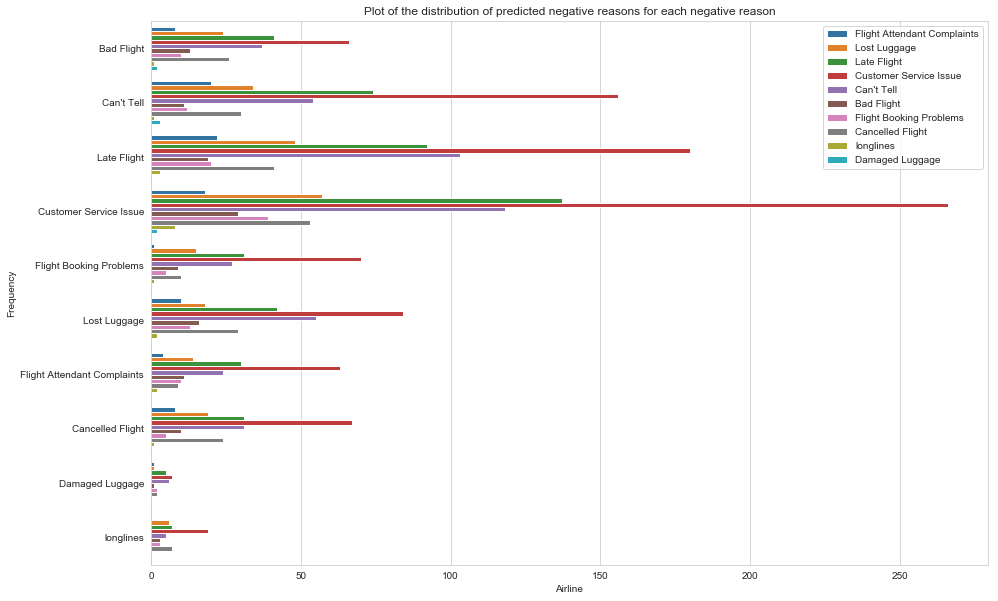

In [48]:
fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)
sns.countplot(y ='negative_reason' , hue='predicted_reasons', data=Airline_negative)

# put legend in the upper right hand corner of the plot
plt.legend(loc=1)
plt.ylabel('Frequency')
plt.xlabel('Airline')
plt.title('Plot of the distribution of predicted negative reasons for each negative reason')

In [49]:
print(AirlineDF.negative_reason.value_counts())

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negative_reason, dtype: int64


Another reason for the accuracy being low is the "Can't Tell" category. This category was the third largest category with 1190 tweets. This is a very generalized category, so the bag of words most likely did not have very good patterns of words to define this category well. Whereas, for examply the "Late Flight" category of tweets may have had a high occurence of the words "late" and "flight" in them.

I think the results may have been skewed as well because customer service issue is a very broad issue. As I stated earlier, it would be useful to analyze the customer service issue tweets on their own to answer the research question.


### “What can public opinion on Twitter tell us about the US airlines in 2015?” 

In the figure below, I have plotted a distribution of the sentiment for each airline. According to this data, the public views US airlines poorly. However, an argument could be made that people tend to tweet/make reviews about negative experiences rather than positive ones. For each airline, the amount of negative tweets is significantly higher than the positive tweets, with an exception for Virgin Airlines. Virgin Airlines has almost equal positive and negative tweets.
It appears that United Airlines is the least liked airline. The most tweets are directed at them, and it appears it has the largest ratio of negative to positive tweets. 
American Airlines and USAirways had almost identical number of tweets, however USAirways had more negative sentiment tweets, so people possibly favour American Airlines over USAirways. 
Another trend is that the higher the total number of tweets, the higher the ratio of negative to positive tweets is. It would be interesting to view the positive vs negative number of sentiment tweets if Delta were to have a sample of over 3000 tweets to compare with the results of United Airlines.

As discussed previously, Customer Service appears to be the major issue that passengers have with US airlines. It would be beneficial to do further analysis on these specific tweets to find out how each airline's Customer Service could be improved in the future. 


In [50]:
print(AirlineDF.airline.value_counts())

United       3159
American     2415
USAirways    2404
Southwest    1736
Jet Blue     1482
Virgin        342
Delta           2
Name: airline, dtype: int64


Text(0.5, 1.0, 'Plot of the distribution of sentiment for each airline')

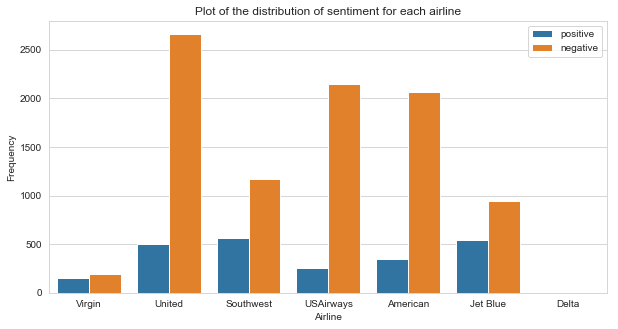

In [51]:
#DF_Virgin = AirlineDF[AirlineDF['airline'] == 'Virgin']

fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,1,1)
sns.countplot(x = 'airline', hue = 'sentiment', data=AirlineDF)

plt.legend(loc=1)
plt.ylabel('Frequency')
plt.xlabel('Airline')
plt.title('Plot of the distribution of sentiment for each airline')

### Model Improvement

There are many ways the logistic regression model could have been improved to get higher accuracy on the testing data. First, due to the nature of tweets, a spell corrector would have been useful. Due to time constraints, and memory issues this could not be implemented. I also noticed that the word "not" is considered a stop word in both the NLTK corpus and the provided stopwords.txt file. I think if using bigrams in the model, having the word "not" could have provided more context for descriptive words in the tweets. For example, if a tweet said "I am not happy", all words except for happy would have been removed. Happy has a score of 3 according to the corpus.txt file and this tweet would be considered a positive tweet. I think customizing the stop words would help with calculating a more accurate Sentiment Score for each tweet.

Another improvement that could be made to get more accurate predictions for the airline sentiment classification would be to train a model using more airline tweets rather than with generic tweets. Having data with more words related to issues with airlines would make the model more accurate, as the bag of words would contain a lot more relevant words needed to understand the content of the tweet. 

In order to improve the second model, in which the negative airline tweets are set as the testing/training data, it would most likely be useful to gather more data in the negative reason categories that had a low number of tweets such as Damaged Luggage and Long Lines. Additionally, removing the "Can't Tell" category and moving those tweets into more descriptive classifications may improve the model as well. 

In [52]:
print("My program took", (time.time() - start_time)/60, "minutes to run")

My program took 7.915046592553456 minutes to run
